# Consistency diffusion network

Frame number of video is denoted as 

$$f=1, f=2, f=3, \cdots, f = F$$

Time step of diffusion process is denoted as 

$$t=T, t=T-1, \cdots, t=0$$

**Input:** F frames of hed edge images are denoted as 

$$h_1, h_2, \cdots, h_F$$

The initial ($t=T$) noisy latents for frame $f=f$ are denoted as

$$i_1^T, i_2^T, \cdots, i_F^T$$

The denoising step goes from t to t-1, at time $t=t$ the noisy latents for frame $f=f$ are denoted as

$$i_1^t, i_2^t, \cdots, i_F^t$$

**Output:** The output video frames are denoted as 

$$i_1^0, i_2^0, \cdots, i_F^0$$

**Controlnet:** For a standard inference method, at each time step, we predict next time step as $i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$

Starting from noisy latents at time $t =t$, we jointly optimize successive frames $i_f^t,i_{f-1}^t$ to minimize the consistency loss:

$$ \underset{i_f^t,i_{f-1}^t}{argmin}\quad ||[i_f^t - Controlnet(h_{f-1},i_f^t] - [i_{f-1}^{t} - Controlnet(h_{f},i_{f-1}^t]||$$

After we get the consistency for all the frames, we can run the standard inference of controlnet for current frame.


$$i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$$


The procedures will be done for all time step $t$ till time step $t=T$ when we have the output video




In [1]:
from base64 import b64encode
import os

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline, UniPCMultistepScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import numpy as np
import torchvision.transforms.functional as F
from einops import rearrange

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load images

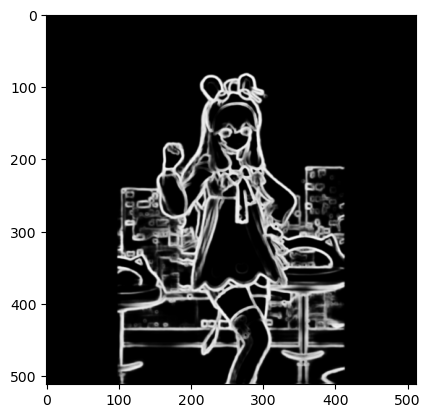

In [2]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')
        
root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# hed图片位置
hed_img_path = os.path.join(root_path, "transfered_images")
file_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num = 100
hed_img_list = []
for i in range(img_num):
    filename = str(i+1) + ".png"
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512))   
    hed_img_list.append(hed_image)
plt.imshow(hed_image)

# Test original pipeline

In [3]:
# Loading model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


pipe = pipe.to("cuda")

## Load hed images and random noise

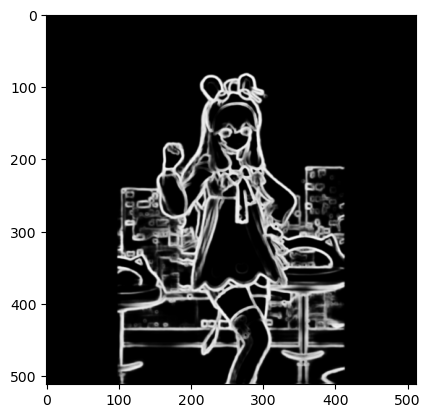

In [4]:
root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# Load images
hed_img_path = os.path.join(root_path, "transfered_images")
file_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num = 100
hed_img_list = []
for i in range(img_num):
    filename = str(i+1) + ".png"
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512))   
    hed_img_list.append(hed_image)
plt.imshow(hed_image)

## Generate random noise

In [5]:
height = 512              
width = 512 
batch_size = 1

noisy_img_list = []

for i in range(img_num):
    # Prep latents
    torch.manual_seed(32)
    latents = torch.randn(
      (batch_size, 4, height // 8, width // 8),
    )
    noisy_img_list.append(latents)
print(torch.allclose(noisy_img_list[0],noisy_img_list[5]))

True


# Run pipeline controlnet as a test

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

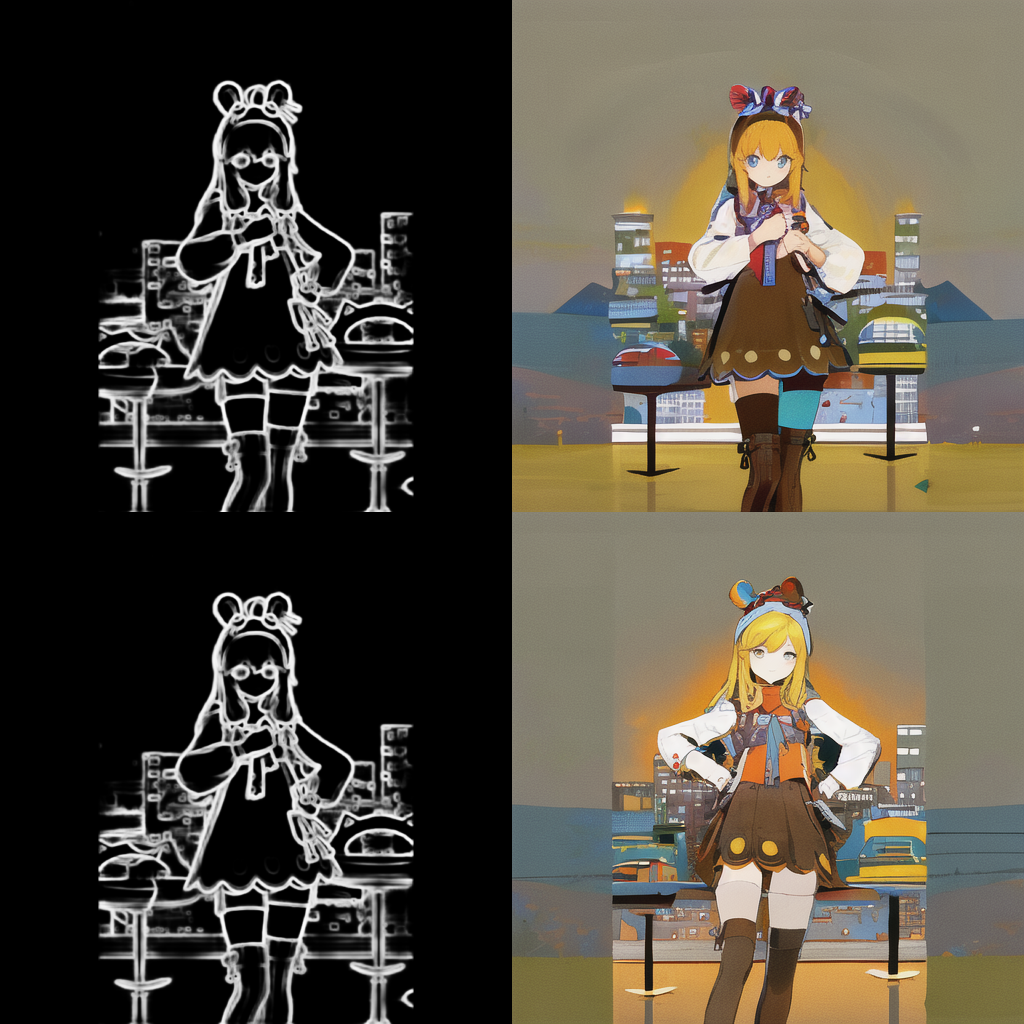

In [6]:
# Loading model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = pipe.to("cuda")

torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output1 = pipe(
    prompt,
    hed_img_list[0],
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)

torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output2 = pipe(
    prompt,
    hed_img_list[50],
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    if not isinstance(imgs[0], np.ndarray):
        w, h = imgs[0].size
        grid = Image.new('RGB', size=(cols*w, rows*h))
        grid_w, grid_h = grid.size
        
        for i, img in enumerate(imgs):
            grid.paste(img, box=(i%cols*w, i//cols*h))
    else:
        w, h = Image.fromarray((imgs[0] * 255).astype(np.uint8)).size
        grid = Image.new('RGB', size=(cols*w, rows*h))
        grid_w, grid_h = grid.size
        
        for i, img in enumerate(imgs):
            grid.paste(Image.fromarray((img * 255).astype(np.uint8)), box=(i%cols*w, i//cols*h))   

    return grid

grid = image_grid([hed_img_list[0], output1[0][0], hed_img_list[1], output2[0][0]], rows=2, cols=2)
grid

# 自定义 Controlnet

Controlnet
https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_controlnet.py#L706

Scheduler
https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py#L77


## 公用部分

In [7]:
vae = pipe.vae.to("cuda")
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")
unet = pipe.unet.to("cuda")
scheduler = pipe.scheduler
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16).to("cuda")

# General settings
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
image = hed_img_list[0]
height = 512
width = 512
num_inference_steps = 20
guidance_scale = 7.5
controlnet_conditioning_scale = 1.0
# 以下是没啥用的
batch_size = 1
device = pipe._execution_device
do_classifier_free_guidance = guidance_scale > 1.0

num_images_per_prompt = 1
eta = 0.0
generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds = None
output_type = "pil"
return_dict = True
callback = None
callback_steps = 1
cross_attention_kwargs = None
# check inputs
pipe.check_inputs(
            prompt,
            image,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            controlnet_conditioning_scale,
        )
        
def decode_latents(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def latents_to_torch_img(latents):
    # input shape [1,4,64,64]
    latents = 1 / vae.config.scaling_factor * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.type(torch.float32)
    # image = image.permute(0, 2, 3, 1)
    # print(image.shape)
    # image = rearrange(image, 'h w c -> 1 c h w')
    return image

class Network(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()

        self.netVggOne = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggTwo = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggThr = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFou = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFiv = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netScoreOne = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreTwo = torch.nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreThr = torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFou = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFiv = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)

        self.netCombine = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=5, out_channels=1, kernel_size=1, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

        self.load_state_dict({strKey.replace('module', 'net'): tenWeight for strKey, tenWeight in torch.load(model_path).items()})

    def forward(self, tenInput):
        tenInput = tenInput * 255.0
        tenInput = tenInput - torch.tensor(data=[104.00698793, 116.66876762, 122.67891434], dtype=tenInput.dtype, device=tenInput.device).view(1, 3, 1, 1)

        tenVggOne = self.netVggOne(tenInput)
        tenVggTwo = self.netVggTwo(tenVggOne)
        tenVggThr = self.netVggThr(tenVggTwo)
        tenVggFou = self.netVggFou(tenVggThr)
        tenVggFiv = self.netVggFiv(tenVggFou)

        tenScoreOne = self.netScoreOne(tenVggOne)
        tenScoreTwo = self.netScoreTwo(tenVggTwo)
        tenScoreThr = self.netScoreThr(tenVggThr)
        tenScoreFou = self.netScoreFou(tenVggFou)
        tenScoreFiv = self.netScoreFiv(tenVggFiv)

        tenScoreOne = torch.nn.functional.interpolate(input=tenScoreOne, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreTwo = torch.nn.functional.interpolate(input=tenScoreTwo, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreThr = torch.nn.functional.interpolate(input=tenScoreThr, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFou = torch.nn.functional.interpolate(input=tenScoreFou, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFiv = torch.nn.functional.interpolate(input=tenScoreFiv, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)

        return self.netCombine(torch.cat([ tenScoreOne, tenScoreTwo, tenScoreThr, tenScoreFou, tenScoreFiv ], 1))
    
remote_model_path = "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/network-bsds500.pth"
# !wget https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/network-bsds500.pth
modelpath = os.path.join("/home/ubuntu/diffusers", "network-bsds500.pth")
hed_network = Network(modelpath).cuda().eval()

# prompt embedding is the same for all frames
with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
    )
# scheduler is shared for all frames
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps
# extra kwargs
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
# denoising warm up steps
num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order

## 准备好每一张condition image和初始化noise

In [8]:
# Prepare one frame (initialize noisy latents and hed images)
def prepare_one_frame(hed_image, seed = 32):
  condition_latents = pipe.prepare_image(
      image=hed_image,
      width=width,
      height=height,
      batch_size=batch_size * num_images_per_prompt,
      num_images_per_prompt=num_images_per_prompt,
      device=device,
      dtype=controlnet.dtype,
      do_classifier_free_guidance=do_classifier_free_guidance,
  )  

  torch.manual_seed(seed)
  num_channels_latents = unet.in_channels
  noisy_latents = pipe.prepare_latents(
      batch_size * num_images_per_prompt,
      num_channels_latents,
      height,
      width,
      prompt_embeds.dtype,
      device,
      generator,
      latents = None,
  )

  return condition_latents, noisy_latents

data_list = []
for i in range(len(hed_img_list)):
  condition_latents, noisy_latents = prepare_one_frame(hed_img_list[i], seed = 32)
  data_list.append([condition_latents, noisy_latents])
print(torch.allclose(data_list[0][1], data_list[10][1]))

True


## 开始denoise

In [9]:
test_results = []
for j in range(5):
    latents = data_list[j * 10][1]
    with torch.no_grad():
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # controlnet(s) inference
            down_block_res_samples, mid_block_res_sample = controlnet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                controlnet_cond=data_list[j * 10][0],
                conditioning_scale=controlnet_conditioning_scale,
                return_dict=False,
            )

            # predict the noise residual
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample
    test_results.append(latents)


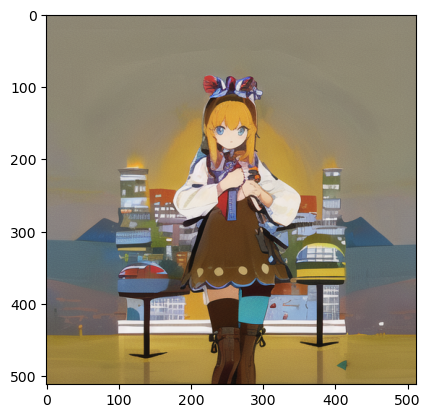

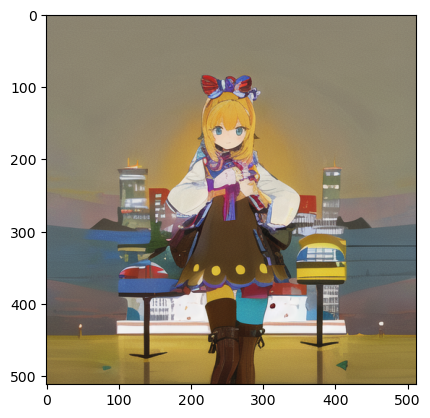

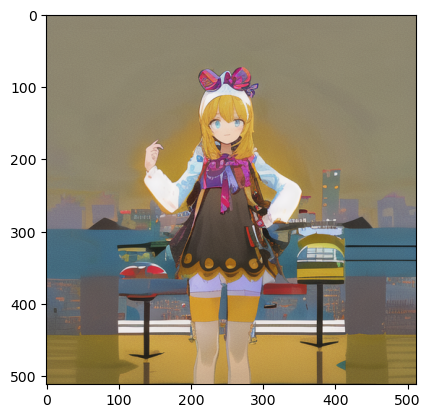

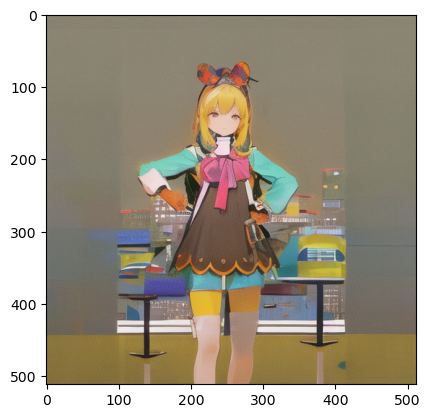

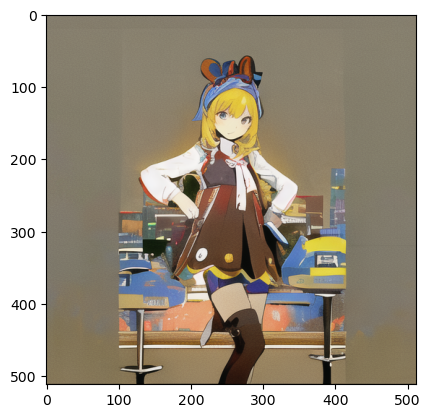

In [10]:
for i in range(5):
  latents = test_results[i].detach()
  image = decode_latents(latents)
  plt.imshow(image[0])
  plt.show()

## Consistent diffusion

In [11]:
def forward_latents_condition(input_latents, condition_img, scheduler, prompt_embeds, t):
  # expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([input_latents] * 2)
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)
  
  assert latent_model_input.shape == torch.Size([2, 4, 64, 64])
  assert prompt_embeds.shape == torch.Size([2, 77, 768])
  assert condition_img.shape == torch.Size([2, 3, 512, 512])

  # controlnet(s) inference
  down_block_res_samples, mid_block_res_sample = controlnet(
      latent_model_input,
      t,
      encoder_hidden_states=prompt_embeds,
      controlnet_cond=condition_img,
      conditioning_scale=controlnet_conditioning_scale,
      return_dict=False,
  )

  # predict the noise residual
  noise_pred = unet(
      latent_model_input,
      t,
      encoder_hidden_states=prompt_embeds,
      cross_attention_kwargs=cross_attention_kwargs,
      down_block_additional_residuals=down_block_res_samples,
      mid_block_additional_residual=mid_block_res_sample,
  ).sample

  # perform guidance
  if do_classifier_free_guidance:
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
  
  return noise_pred

In [12]:
def consistent_loss_1(noise_1, noise_2):
#   error = torch.abs(noise_1 - noise_2).mean() # [:,2] -> all images in batch, only the blue channel
  error = torch.abs(noise_1 - noise_2).mean()
  return error    

def consistent_loss_2(latents_1_1, latents_1_2, latents_2_1, latents_2_2):
  error = torch.abs(latents_1_1 - latents_2_1).mean() + torch.abs(latents_2_2 - latents_1_2).mean()
  return error    

def edge_loss(edge_1, edge_2):
  error  = torch.abs(edge_1 - edge_2).mean()
  return error

In [13]:
torch.cuda.empty_cache()

In [14]:
latents_1 = data_list[0][1].clone().detach()
condition_img_1 = data_list[0][0].clone().detach()
latents_2 = data_list[50][1].clone().detach()
condition_img_2 = data_list[50][0].clone().detach()
scheduler1 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler2 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler1.set_timesteps(num_inference_steps, device=device)
scheduler2.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler1.timesteps
current_prompt_embeds = prompt_embeds.clone().detach()

hed_tensor_1 = torch.tensor(np.array(hed_img_list[0])).to("cuda")
hed_tensor_2 = torch.tensor(np.array(hed_img_list[50])).to("cuda")

prev_list_1 = []
pred_original_list_1 = []
prev_list_2 = []
pred_original_list_2 = []
edge_list_1 = []
edge_list_2 = []

# whether we want to optimize latents
flag_optimize = True

loss_scale_1 = 300
loss_scale_2 = 20
early_stop_steps = 15
learning_steps = 3

for i, t in enumerate(timesteps):

    with torch.no_grad():
        noise_pred_1 = forward_latents_condition(latents_1, condition_img_1, scheduler1, current_prompt_embeds, t)
        noise_pred_2 = forward_latents_condition(latents_2, condition_img_2, scheduler2, current_prompt_embeds, t)

    # optimize latents
    if flag_optimize:
        for _ in range(1):
            latents_1 = latents_1.detach().requires_grad_()
            latents_2 = latents_2.detach().requires_grad_()
            scheduler_temp_1 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            scheduler_temp_1.set_timesteps(num_inference_steps, device=device)
            scheduler_temp_2 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            scheduler_temp_2.set_timesteps(num_inference_steps, device=device)
            scheduler_temp_3 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            scheduler_temp_3.set_timesteps(num_inference_steps, device=device)
            scheduler_temp_4 = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            scheduler_temp_4.set_timesteps(num_inference_steps, device=device)
            noise_pred_1_hed_2 = forward_latents_condition(latents_1, condition_img_2, scheduler_temp_1, current_prompt_embeds, t)
            scheduler_temp = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            noise_pred_2_hed_1 = forward_latents_condition(latents_2, condition_img_1, scheduler_temp_2, current_prompt_embeds, t)
            scheduler_temp = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            noise_pred_1_hed_1 = forward_latents_condition(latents_1, condition_img_1, scheduler_temp_3, current_prompt_embeds, t)
            scheduler_temp = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
            noise_pred_2_hed_2 = forward_latents_condition(latents_2, condition_img_2, scheduler_temp_4, current_prompt_embeds, t)

            latents_x0_1_pred_1_hed_1  = scheduler_temp_1.step(noise_pred_1_hed_1, t, latents_1, **extra_step_kwargs).pred_original_sample
            latents_x0_1_pred_1_hed_2  = scheduler_temp_2.step(noise_pred_1_hed_2, t, latents_1, **extra_step_kwargs).pred_original_sample
            latents_x0_2_pred_2_hed_1  = scheduler_temp_3.step(noise_pred_2_hed_1, t, latents_2, **extra_step_kwargs).pred_original_sample
            latents_x0_2_pred_2_hed_2  = scheduler_temp_4.step(noise_pred_2_hed_2, t, latents_2, **extra_step_kwargs).pred_original_sample

            # # 增加一两个loss，使 1和1 以及 2和2 都要求和对应的hed搞起来
            img_x0_1_pred_1_hed_1 = latents_to_torch_img(latents_x0_1_pred_1_hed_1)
            img_x0_2_pred_2_hed_2 = latents_to_torch_img(latents_x0_2_pred_2_hed_2)
            print(img_x0_1_pred_1_hed_1.dtype)
            edge_1 = hed_network(img_x0_1_pred_1_hed_1)
            edge_1 = torch.permute(edge_1[0], (1, 2, 0)).repeat(1,1,3)
            edge_2 = hed_network(img_x0_2_pred_2_hed_2)
            edge_2 = torch.permute(edge_2[0], (1, 2, 0)).repeat(1,1,3)

            loss_consistent = consistent_loss_2(latents_x0_1_pred_1_hed_1, latents_x0_1_pred_1_hed_2, latents_x0_2_pred_2_hed_1, latents_x0_2_pred_2_hed_2) * loss_scale_1
            loss_edge_1 = edge_loss(edge_1[0], hed_tensor_1) * loss_scale_2
            loss_edge_2 = edge_loss(edge_2[0], hed_tensor_2) * loss_scale_2
            print(i, 'loss:', loss_consistent.item(), loss_edge_1.item(), loss_edge_2.item())

            if i < early_stop_steps:
                print("use loss 1")
                loss = (loss_consistent + loss_edge_1 + loss_edge_2)
            else:
                print("use loss 2")
                loss = loss_edge_1 + loss_edge_2

            cond_grad_1, cond_grad_2 = torch.autograd.grad(loss, [latents_1, latents_2])
            sigma = scheduler2.sigmas[i]
            # Modify the latents based on this gradient
            latents_2 = latents_2.detach() - cond_grad_2 * sigma**2   
            latents_1 = latents_1.detach() - cond_grad_1 * sigma**2   

    with torch.no_grad():
        # store original sample
        latents_x0_1 = scheduler1.step(noise_pred_1, t, latents_1, **extra_step_kwargs).pred_original_sample
        latents_x0_2 = scheduler2.step(noise_pred_2, t, latents_2, **extra_step_kwargs).pred_original_sample   

        # compute the previous noisy sample x_t -> x_t-1
        latents_1 = scheduler1.step(noise_pred_1, t, latents_1, **extra_step_kwargs).prev_sample
        latents_2 = scheduler2.step(noise_pred_2, t, latents_2, **extra_step_kwargs).prev_sample

        prev_list_1.append(latents_to_pil(latents_1)[0])
        prev_list_2.append(latents_to_pil(latents_2)[0])
        pred_original_list_1.append(latents_to_pil(latents_x0_1)[0])
        pred_original_list_2.append(latents_to_pil(latents_x0_2)[0])


torch.float32
0 loss: 11.3671875 520.8203735351562 573.8885498046875
use loss 1
torch.float32
1 loss: 684.0 519.7583618164062 572.931640625
use loss 1
torch.float32
2 loss: 2362.0 519.7741088867188 572.9734497070312
use loss 1
torch.float32
3 loss: 1120.0 519.713134765625 572.991455078125
use loss 1
torch.float32
4 loss: 609.5 519.93310546875 572.9303588867188
use loss 1
torch.float32
5 loss: 298.25 519.7174072265625 572.930419921875
use loss 1
torch.float32
6 loss: 186.75 519.7132568359375 572.930419921875
use loss 1
torch.float32
7 loss: 149.0 519.7130737304688 572.930419921875
use loss 1
torch.float32
8 loss: 115.75 519.7129516601562 572.930419921875
use loss 1
torch.float32
9 loss: 97.3125 519.7130737304688 572.930419921875
use loss 1
torch.float32
10 loss: 84.25 519.7129516601562 572.930419921875
use loss 1
torch.float32
11 loss: 76.75 519.7130126953125 572.930419921875
use loss 1
torch.float32
12 loss: 67.5 519.7130126953125 572.930419921875
use loss 1
torch.float32
13 loss: 65.6

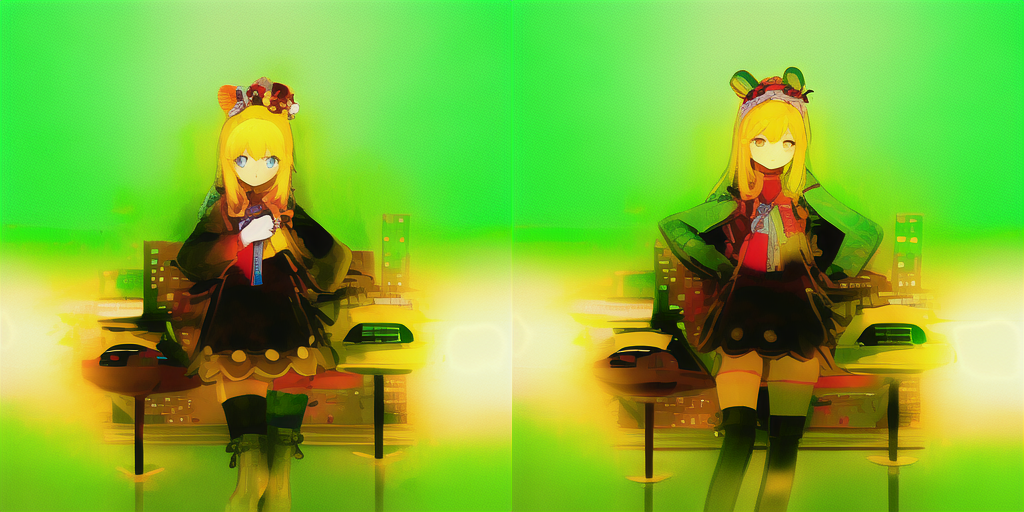

In [15]:
latents_1 = latents_1.detach()
image_1 = decode_latents(latents_1)
latents_2 = latents_2.detach()
image_2 = decode_latents(latents_2)
grid = image_grid([image_1[0],image_2[0]],1,2)
grid

In [16]:
temp_grid = image_grid(prev_list_1 + pred_original_list_1 + prev_list_2 + pred_original_list_2,4,20)
temp_grid.save("test.png")

In [17]:
scheduler2.sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000], device='cuda:0')

In [18]:
edge_1.shape

torch.Size([512, 512, 3])

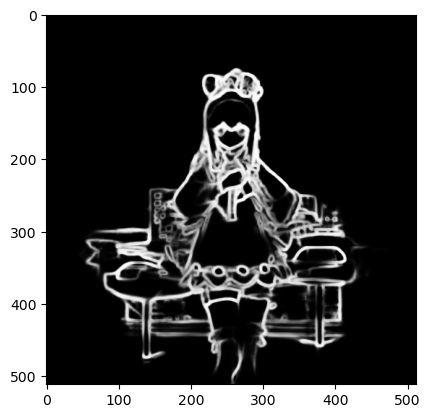

In [19]:
plt.imshow(edge_1.detach().cpu())

In [20]:
scheduler1.

SyntaxError: invalid syntax (1444980867.py, line 1)